---
---
# <span style="color:orange">__Michael Evan__</span>
---
---
- Student #: 02081213
- mevan@umassd.edu
- CIS602 Intro to Deep Learning: Project 2
- Due: 11/4/2025
- University of Massachussetts
- Graduate Computer Science Department
- Fall 2025
---
---
## <span style="color:green">__The Project Utilizes the PyTorch SmallCountNet CNN__</span>
---
---
### <span style="color:orange">__Model attempts to predict the number of specific shapes in an image frame__</span>
#### <span style="color:orange">__Adam Optimizer & L1Loss function are utilized in the project__</span>
#### <span style="color:orange">__Custom Python script coded: produces image frames & .csv database__</span>
#### <span style="color:orange">__On Apple Silicon Apple's GPU backend mps (Metal Performance Shaders) utilized ... Metal (M1/M2)__</span>
- <span style="color:orange">Image "data" directory created on first execution</span>
- <span style="color:orange">Images are 64x64 pixels by default and adjustable</span>
- <span style="color:orange">Random size shapes are generated: Circles, Squares and Triangles</span>
- <span style="color:orange">Default number each shape random 0 to 5 in each frame and adjustable</span>
- <span style="color:orange">Images stored as .png file in "shape_data" directory</span>
- <span style="color:orange">Three .csv files generated:</span>
- <span style="color:orange">labels.csv</span> - master file lists every image and its counts. Columns: filename, circle, square, triangle
- <span style="color:orange">train.csv</span> - subset of labels.csv used for training (same columns); created by sampling from labels.csv
- <span style="color:orange">val.csv</span> - subset of labels.csv used for validation (same columns); contains remaining rows after train / split
###
---
---
### ********** IMPORTANT! **********

#### ***** Program is written to not over-write an existing "shape_data" directory *****
- If making changes to:
- number of images (N_IMAGES)
- image size (IMG_SIZE)
- maximum # of each shape / image (MAX_EACH)
#### Changes require deleting the "data" directory which contains the images & the .csv files
- <span style="color:orange">A new "data" directory will be created with the desired changes</span>
##### 
##### Changes: number of EPOCHS or BATCH require no deletion of "shape_data" directory
---
---

In [1]:
#%pip install pandas tqdm
#%pip install matplotlib seaborn scikit-learn

- <span style="color:orange">__Dependencies imports__</span>

In [2]:
#!/usr/bin/env python3
import os
import sklearn as sk
import random
import numpy as np
from PIL import Image, ImageDraw
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt
import pandas as pd
import warnings

In [3]:
warnings.filterwarnings("ignore")

- <span style="color:orange">__Configuration__</span>
- <span style="color:orange">__Adjust values as needed__</span>
- <span style="color:orange">__Note: no "shape_data" directory over-write ... must be deleted if image changes__</span>

In [4]:
OUT_DIR = "shape_data"  # output directory for generated images
IMG_SIZE = 64           # image size (IMG_SIZE x IMG_SIZE)
N_IMAGES = 5000         # number of images to generate
MAX_EACH = 5            # max number of each shape per image
BATCH = 64              # training batch size
EPOCHS = 100            # number of training epochs
SEED = 42               # random seed for reproducibility
NUM_WORKERS = 0         # number of DataLoader workers (0 for Windows)
HEADTAIL_N = 10         # number of lines to show from head/tail of outputs

- <span style="color:orange">__Set random seeds for reproducibility__</span>

In [5]:
random.seed(SEED)       
np.random.seed(SEED)    
torch.manual_seed(SEED) 

- <span style="color:orange">__function draws random # shapes / image__</span>
- <span style="color:orange">__shapes: circles, squares, triangles__</span>
- <span style="color:orange">__no overlapping of shapes for accurate counts__</span>

In [6]:
def draw_random_shapes(size, req_counts):   
    canvas = Image.new("L", (size, size), 0)
    draw_canvas = ImageDraw.Draw(canvas)
    occ = np.zeros((size, size), dtype=np.uint8)

    shapes = []
    for _ in range(req_counts[0]):
        r = random.randint(max(3, size // 16), max(6, size // 6))   # radius
        shapes.append(("circle", r))
    for _ in range(req_counts[1]):
        s = random.randint(max(4, size // 16), max(10, size // 6))  # side length
        shapes.append(("square", s))
    for _ in range(req_counts[2]):
        s = random.randint(max(6, size // 12), max(12, size // 5))  # side length
        shapes.append(("triangle", s))

    shapes.sort(key=lambda x: x[1], reverse=True)   # place larger shapes first
    max_attempts = 200
    placed_counts = {"circle": 0, "square": 0, "triangle": 0}   # track placed shapes

    for kind, sz in shapes:             # attempt to place each shape
        placed = False                  # flag for successful placement
        for _ in range(max_attempts):   # try to place shape
            if kind == "circle":        # circle
                r = sz                  # radius
                x = random.randint(r, size - 1 - r)     # center x
                y = random.randint(r, size - 1 - r)     # center y
                temp = Image.new("L", (size, size), 0)  # blank temp image
                ImageDraw.Draw(temp).ellipse((x - r, y - r, x + r, y + r), fill=255)    # draw circle
            elif kind == "square":      # square
                s = sz                  # side length
                x = random.randint(0, size - 1 - s)     # top-left x
                y = random.randint(0, size - 1 - s)     # top-left y
                temp = Image.new("L", (size, size), 0)  # blank temp image
                ImageDraw.Draw(temp).rectangle((x, y, x + s, y + s), fill=255)  # draw square
            else:
                s = sz                  # triangle
                x = random.randint(0, size - 1 - s)     # top-left x
                y = random.randint(0, size - 1 - s)     # top-left y
                pts = [(x, y + s), (x + s // 2, y), (x + s, y + s)] # triangle points
                temp = Image.new("L", (size, size), 0)              # blank temp image
                ImageDraw.Draw(temp).polygon(pts, fill=255)         # draw triangle

            tmask = (np.array(temp) > 0).astype(np.uint8)   # temp mask
            if np.any(tmask & occ):                         # overlap detected
                continue                                    # try again
            draw_canvas.bitmap((0, 0), temp, fill=255)      # draw shape on canvas
            occ |= tmask                # update occupancy map
            placed_counts[kind] += 1    # increment placed count
            placed = True               # successful placement
            break                       # exit attempts loop
        if not placed:                  # failed to place shape
            continue                    # skip to next shape

    arr = np.array(canvas).astype(np.float32)   # convert to array
    arr += np.random.randn(*arr.shape) * 8.0    # add noise
    arr = np.clip(arr, 0, 255).astype(np.uint8) # clip to valid range
    return Image.fromarray(arr), [placed_counts["circle"], placed_counts["square"], placed_counts["triangle"]]  # return image and actual counts


- <span style="color:orange">__Generate dataset of images with random shapes and save to disk__</span>

In [7]:
def generate_dataset(out_dir=OUT_DIR, n=N_IMAGES):  
    os.makedirs(out_dir, exist_ok=True) # create output directory
    labels = []                         # list to hold labels
    for i in range(n):                  # generate n images
        req = [random.randint(0, MAX_EACH) for _ in range(3)]   # random required counts
        img, actual = draw_random_shapes(IMG_SIZE, req) # draw image
        fn = f"img_{i:05d}.png"                         # filename
        img.save(os.path.join(out_dir, fn))             # save image
        labels.append((fn, actual[0], actual[1], actual[2]))    # store label
    with open(os.path.join(out_dir, "labels.csv"), "w") as f:   # save labels to CSV
        f.write("filename,circle,square,triangle\n")            # header
        for row in labels:                                      # write each label
            f.write(f"{row[0]},{row[1]},{row[2]},{row[3]}\n")   # label row
    print(f"Generated {len(labels)} images -> {out_dir}")       # done

- <span style="color:orange">__Dataset class for shape images__</span>

In [8]:
class ShapesDataset(Dataset):   # dataset for shape images
    def __init__(self, csv_path, img_dir, transform=None):  # initialize dataset
        import csv              # import csv module
        self.items = []         # list to hold dataset items
        self.img_dir = img_dir  # directory of images
        with open(csv_path, newline='') as f:   # open CSV file
            r = csv.DictReader(f)               # read CSV as dictionary
            for row in r:                       # for each row
                # ensure correct order: filename, circle, square, triangle
                self.items.append((row['filename'],         # filename
                                   int(row['circle']),      # circle count
                                   int(row['square']),      # square count
                                   int(row['triangle'])))   # triangle count
        self.transform = transform  # image transformations
        
    ''' number of items in dataset '''
    def __len__(self):  
        return len(self.items)  # return dataset size

    ''' get item at index idx '''
    def __getitem__(self, idx):
        fn, c, s, t = self.items[idx]           # get item info
        path = os.path.join(self.img_dir, fn)   # full image path
        img = Image.open(path).convert("L")     # load image as grayscale
        if self.transform:                      # apply transformations
            img = self.transform(img)           # transform image
        labels = torch.tensor([c, s, t], dtype=torch.float32)   # create label tensor
        return img, labels                      # return image and labels

# - <span style="color:orange">__SmallCountNet CNN model for counting shapes__</span>

In [9]:
class SmallCountNet(nn.Module):
    def __init__(self): 
        super().__init__()                      # initialize parent class
        self.features = nn.Sequential(          # feature extraction layers
            nn.Conv2d(1, 16, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),     # 64x64 -> 32x32
            nn.Conv2d(16, 32, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),    # 32x32 -> 16x16
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),    # 16x16 -> 8x8
        )
        self.pool = nn.AdaptiveAvgPool2d((1, 1))    # adaptive pooling to 1x1
        # NOTE: final activation removed (no ReLU after final linear)
        self.head = nn.Sequential(  # fully connected head
            nn.Flatten(),           # flatten features
            nn.Linear(64, 64), nn.ReLU(),   # hidden layer
            nn.Linear(64, 3)                # output layer for 3 shape counts
        )
        
    ''' forward pass '''
    def forward(self, x):   
        x = self.features(x)    # extract features
        x = self.pool(x)        # pool to 1x1
        x = self.head(x)        # pass through head
        return x                # return output


- <span style="color:orange">__Print sample predictions on Validation set__</span>
- <span style="color:orange">__GT (ground truth counts) and P (model predictions, rounded)__</span>

In [10]:
def print_head_tail(lines, n=HEADTAIL_N, label=None):
    print()
    if label:                   # print label if provided
        print(f"--- {label} (showing head {n} / tail {n}) ---") # print label
    total = len(lines)          # total number of lines
    if total == 0:              # no lines to print
        print("(empty)")        
        return
    head = lines[:n]            # get head lines
    tail = lines[-n:] if total > n else []  # get tail lines
    for l in head:              # print head lines
        print(l)
    if total > 2 * n:           # if more than head+tail lines
        print(f"... ({total - 2*n} lines omitted) ...") # indicate omitted lines
        for l in tail:           # print tail lines
            print(l)

- <span style="color:orange">__Plot Learning Curves__</span>

In [11]:
def plot_learning_curves(train_losses, val_losses, title='Learning Curves', out=None, show=True):
    import matplotlib.pyplot as plt
    fig, ax = plt.subplots(figsize=(7,4))
    epochs = range(1, len(train_losses) + 1)
    ax.plot(epochs, train_losses, label='train loss')
    ax.plot(epochs, val_losses, label='val loss')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss (MAE)')
    ax.set_title(title)
    ax.legend()
    ax.grid(alpha=0.3)
    fig.tight_layout()
    if out:
        fig.savefig(out, dpi=150)
    if show:
        plt.show()
    plt.close(fig)

### <span style="color:orange">__Individual Scatter Plots actual vs predicted counts for each shape__</span>
##### <span style="color:orange">__value:frequency counts in each subplot__</span>
- <span style="color:orange">__ex: 2:20 means 2 circles created in 20 frames__</span>


In [12]:
def plot_actual_vs_pred(model, val_loader, device, out="actual_vs_pred.png"):
    model.eval()
    ys_true, ys_pred = [], []
    with torch.no_grad():
        for xb, yb in val_loader:           # validation loop
            xb = xb.to(device)  
            pred = model(xb).cpu().numpy()  # get predictions
            ys_pred.append(pred)            # store predictions
            ys_true.append(yb.numpy())      # store true labels
    ys_true = np.vstack(ys_true)            # stack true labels
    ys_pred = np.vstack(ys_pred)            # stack predictions

    abs_err = np.abs(ys_pred - ys_true)     # absolute error
    mae = abs_err.mean(axis=0)              # mean absolute error
    rmse = np.sqrt(((ys_pred - ys_true)**2).mean(axis=0))   # root mean squared error
    classes = ["circle", "square", "triangle"]              # class names
    
    for i, c in enumerate(classes):                         # print metrics
        print(f"{c}: MAE={mae[i]:.3f}  RMSE={rmse[i]:.3f}")

    fig, axes = plt.subplots(1, 3, figsize=(13, 4))         # create subplots
    
    ''' Add value:frequency counts to each subplot ex: "0:12 1:34 2:20 ..."'''
    for i, ax in enumerate(axes):
        counts = np.bincount(ys_true[:, i].astype(int), minlength=MAX_EACH+1) # value counts
        parts = [f"{v}:{counts[v]}" for v in range(len(counts))]    
        counts_str = "value:frequency\n\n" + "  ".join(parts)   # format counts string
        ax.text(0.02, 0.95, counts_str, transform=ax.transAxes, # add text to plot
                fontsize=8, va='top', ha='left', bbox=dict(alpha=0.0))
        
    ''' Create scatter plots for each class '''
    for i, ax in enumerate(axes):                           # plot each class 
        ax.scatter(ys_true[:, i], ys_pred[:, i], alpha=0.5, s=12)   # scatter plot
        # compute integer bounds and clip to valid range
        mn = min(ys_true[:, i].min(), ys_pred[:, i].min())  # min value
        mx = max(ys_true[:, i].max(), ys_pred[:, i].max())  # max value
        mn = int(np.floor(mn))      # floor to int
        mx = int(np.ceil(mx))       # ceil to int
        mn = max(mn, 0)
        mx = min(mx, MAX_EACH)      # ensure within 0..MAX_EACH
        # set axis limits and integer ticks
        ax.set_xlim(mn - 0.2, mx + 0.2)         # set x limits
        ax.set_ylim(mn - 0.2, mx + 0.2)         # set y limits
        ax.set_xticks(np.arange(mn, mx + 1))    # x ticks
        ax.set_yticks(np.arange(mn, mx + 1))    # y ticks
        ax.plot([mn, mx], [mn, mx], 'r--', linewidth=1)             # y=x line
        ax.set_xlabel("Actual")                                     # x label
        ax.set_ylabel("Predicted")                                  # y label
        ax.set_title(f"{classes[i]} (MAE={mae[i]:.2f})")            # title with MAE
        ax.set_xlim(mn - 0.5, mx + 0.5)                             # set x limits
        ax.set_ylim(mn - 0.5, mx + 0.5)                             # set y limits
    fig.tight_layout()           # adjust layout
    fig.savefig(out, dpi=150)    # save figure
    print(f"Saved scatter plot to {out}")   # print save message
    plt.show() # show scatter plot    

### <span style="color:orange">__Plot error historgram__</span>

In [13]:
def plot_error_hist_and_box(model, val_loader, device,
                            out_hist="error_hist.png", out_box="error_box.png"): 
    model.eval()
    ys_true, ys_pred = [], []
    with torch.no_grad():
        for xb, yb in val_loader:
            xb = xb.to(device)
            pred = model(xb).cpu().numpy()
            ys_pred.append(pred)
            ys_true.append(yb.numpy())
    ys_true = np.vstack(ys_true)
    ys_pred = np.vstack(ys_pred)

    errs = ys_pred - ys_true            # signed errors
    abs_errs = np.abs(errs)            # absolute errors
    classes = ["circle", "square", "triangle"]

    # Histogram of signed errors (one subplot per class)
    fig, axes = plt.subplots(1, 3, figsize=(12, 3))
    bins = np.arange(-6.5, 7.5, 1)     # integer-centered bins
    for i, ax in enumerate(axes):
        ax.hist(errs[:, i], bins=bins, color=f"C{i}", alpha=0.8)
        ax.axvline(0, color="k", linestyle="--", linewidth=1)
        ax.set_title(f"{classes[i]} error histogram")
        ax.set_xlabel("pred - actual")
        ax.set_ylabel("count")
        ax.set_xlim(bins[0], bins[-1])
    fig.tight_layout()
    fig.savefig(out_hist, dpi=150)
    plt.show()

    # Boxplot of absolute errors
    fig, ax = plt.subplots(figsize=(6, 4))
    ax.boxplot([abs_errs[:, i] for i in range(3)], labels=classes, showmeans=True)
    ax.set_ylabel("Absolute error")
    ax.set_title("Absolute error distribution (per class)")
    fig.tight_layout()
    fig.savefig(out_box, dpi=150)
    plt.show()

    # Optional quick stats
    within1 = (abs_errs <= 1).mean(axis=0)
    within2 = (abs_errs <= 2).mean(axis=0)
    for i, c in enumerate(classes):
        print(f"{c}: % within ±1 = {within1[i]*100:.1f}%, % within ±2 = {within2[i]*100:.1f}%")

### <span style="color:orange">__Confusion-matrix plots for each shape__</span>

In [14]:
try:
    from sklearn.metrics import confusion_matrix
    _have_sklearn = True
except Exception:
    _have_sklearn = False

def plot_confusion_matrices(ys_true, ys_pred, max_count=None, normalize=False, out="confusion_matrices.png"):
    # ys_true, ys_pred: (N,3) arrays
    ys_true = np.asarray(ys_true)
    ys_pred = np.asarray(ys_pred)
    assert ys_true.shape == ys_pred.shape and ys_true.shape[1] == 3

    if max_count is None:   
        max_count = int(max(ys_true.max(), np.ceil(ys_pred.max())))
    classes = np.arange(0, max_count+1)

    # convert preds to integer classes
    preds_int = np.clip(np.rint(ys_pred).astype(int), 0, max_count)
    true_int  = np.clip(np.rint(ys_true).astype(int), 0, max_count)

    fig, axes = plt.subplots(1, 3, figsize=(15, 4))
    names = ["circle", "square", "triangle"]
    for i, ax in enumerate(axes):
        t = true_int[:, i]
        p = preds_int[:, i]

        if _have_sklearn:
            cm = confusion_matrix(t, p, labels=classes)
        else:
            # fallback: build by bincount
            cm = np.zeros((len(classes), len(classes)), dtype=int)
            for a, b in zip(t, p):
                cm[a, b] += 1

        if normalize:
            row_sums = cm.sum(axis=1, keepdims=True)
            cm_display = cm.astype(float) / np.maximum(row_sums, 1)
        else:
            cm_display = cm

        im = ax.imshow(cm_display, cmap="Oranges", origin="lower")
        ax.set_title(names[i])
        ax.set_xlabel("Predicted")
        ax.set_ylabel("Actual")
        ax.set_xticks(np.arange(len(classes)))
        ax.set_yticks(np.arange(len(classes)))
        ax.set_xticklabels(classes)
        ax.set_yticklabels(classes)
        plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

        # annotate counts (or percentages if normalized)
        for r in range(cm.shape[0]):
            for c in range(cm.shape[1]):
                v = cm_display[r, c]
                txt = f"{v:.2f}" if normalize else f"{int(cm[r, c])}"
                ax.text(c, r, txt, ha="center", va="center", color="black", fontsize=8)

    fig.tight_layout()
    fig.savefig(out, dpi=150)
    print()
    print(f"Saved confusion matrices to {out}") # print save message
    print("Confusion Matrices (rows: actual, columns: predicted) for each shape of test set:")
    plt.show()


### <span style="color:orange">__Evaluate on a given DataLoader__</span>

In [15]:
def evaluate_loader(model, loader, device): # evaluate on given DataLoader
    model.eval()
    ys_true, ys_pred = [], []   # lists to hold true and predicted values
    with torch.no_grad():
        for xb, yb in loader:   # iterate over batches
            xb = xb.to(device)  # move inputs to device
            pred = model(xb).cpu().numpy()  # get predictions
            ys_pred.append(pred)            # store predictions
            ys_true.append(yb.numpy())      # store true labels
    ys_true = np.vstack(ys_true)            # stack true labels
    ys_pred = np.vstack(ys_pred)            # stack predictions
    abs_err = np.abs(ys_pred - ys_true)     # absolute error
    mae = abs_err.mean(axis=0)              # mean absolute error
    rmse = np.sqrt(((ys_pred - ys_true)**2).mean(axis=0))       
    return ys_true, ys_pred, mae, rmse      # return results


### <span style="color:orange">__Train the model__</span>
- <span style="color:orange">__train() creates SmallCountNet() CNN__</span>
- <span style="color:orange">__model moved to selected device__</span>
- <span style="color:orange">__training on image tensors from ShapeDataset using Adam & nn.L1Loss__</span>
- <span style="color:orange">__note: utilizing 80/10/10 Train/Validation/Test__</span>


In [ ]:
''' Train the model '''
def train():
    # select device
    device = torch.device("cuda" if torch.cuda.is_available() else
                          "mps" if getattr(torch.backends, "mps", None) is not None and torch.backends.mps.is_available() else
                          "cpu")    
    print("Using device:", device)     # print selected device
    
    if not os.path.exists(os.path.join(OUT_DIR, "labels.csv")): # check if dataset exists
        generate_dataset()  # generate a dataset if not existing

    transform = transforms.Compose([                # image transformations
        transforms.Resize((IMG_SIZE, IMG_SIZE)),    # resize to IMG_SIZE
        transforms.ToTensor(),                      # convert to tensor
        transforms.Normalize([0.5], [0.5])          # normalize to [-1, 1]
    ])

    df = pd.read_csv(os.path.join(OUT_DIR, "labels.csv"))   # load labels CSV
    
    # 80/10/10 split
    train_df = df.sample(frac=0.8, random_state=SEED)
    rest = df.drop(train_df.index)
    val_df = rest.sample(frac=0.5, random_state=SEED)   # half of rest -> 10% total
    test_df = rest.drop(val_df.index)                    # remaining 10%
    # save csvs is optional
    train_df.to_csv(os.path.join(OUT_DIR, "train.csv"), index=False)
    val_df.to_csv(os.path.join(OUT_DIR, "val.csv"), index=False)
    test_df.to_csv(os.path.join(OUT_DIR, "test.csv"), index=False)

    train_ds = ShapesDataset(os.path.join(OUT_DIR, "train.csv"), OUT_DIR, transform)
    val_ds   = ShapesDataset(os.path.join(OUT_DIR, "val.csv"), OUT_DIR, transform)
    test_ds  = ShapesDataset(os.path.join(OUT_DIR, "test.csv"),  OUT_DIR, transform)

    train_loader = DataLoader(train_ds, batch_size=BATCH, shuffle=True,  num_workers=NUM_WORKERS)
    val_loader   = DataLoader(val_ds,   batch_size=BATCH, shuffle=False, num_workers=NUM_WORKERS)
    test_loader  = DataLoader(test_ds,  batch_size=BATCH, shuffle=False, num_workers=NUM_WORKERS)
    
    # create model AFTER dataset to init final-bias to label means
    model = SmallCountNet().to(device)

    # initialize final linear bias to training label means (helps avoid collapsed outputs)
    try:
        means = train_df[['circle', 'square', 'triangle']].mean().values.astype(np.float32) # compute means
        # find the final linear weight/bias parameter and set bias
        # our head is Sequential(Flatten, Linear(64,64), ReLU, Linear(64,3))
        final_linear = None             # placeholder for final linear layer
        for m in model.modules():       # find final linear layer
            if isinstance(m, nn.Linear) and m.out_features == 3:    # check output features
                final_linear = m        # set bias to means
        if final_linear is not None:    # if found, set bias
            with torch.no_grad():       # disable gradients
                final_linear.bias.copy_(torch.from_numpy(means).to(final_linear.bias.device))   # set bias
    except Exception: 
        pass  # non-critical

    ''' set up Adam optimizer and L1 Loss function '''
    opt = optim.Adam(model.parameters(), lr=1e-3) # Adam optimizer
    criterion = nn.L1Loss()                       # L1 loss (MAE)
    best_val = float('inf')     # best validation loss
    best_epoch = -1             # best epoch number
    train_losses = []           # to store training losses
    val_losses = []             # to store validation losses
    
    for epoch in range(EPOCHS): # training epochs
        model.train()
        running_loss = 0.0
        for xb, yb in train_loader: # training loop
            xb, yb = xb.to(device), yb.to(device)       # move to device
            pred = model(xb)                            # forward pass
            loss = criterion(pred, yb)                  # compute loss
            opt.zero_grad()                             # zero gradients
            loss.backward()                             # backpropagation
            opt.step()                                  # optimizer step
            running_loss += loss.item() * xb.size(0)    # accumulate loss
        train_loss = running_loss / len(train_ds)       # average train loss

        # validation
        model.eval()                # set eval mode
        val_loss = 0.0              # initialize val loss
        val_mae_per_image = 0.0     # initialize val MAE per image
        with torch.no_grad():       # disable gradients
            for xb, yb in val_loader:                   # validation loop
                xb, yb = xb.to(device), yb.to(device)   # move to device
                pred = model(xb)                        # forward pass
                val_loss += criterion(pred, yb).item() * xb.size(0) # accumulate val loss
                val_mae_per_image += torch.abs(pred - yb).mean(dim=1).sum().item()  # accumulate per-image MAE
        val_loss /= len(val_ds)                         # average val loss
        val_mae_per_image /= len(val_ds)                # average val MAE per image
        
        train_losses.append(train_loss)  # append train loss
        val_losses.append(val_loss)      # append val loss
     
        print(f"Epoch {epoch+1}/{EPOCHS}  train_loss={train_loss:.4f}  val_loss={val_loss:.4f}  val_mae_per_image={val_mae_per_image:.4f}")

        if val_loss < best_val:     # check for best val loss
            best_val = val_loss     # update best val loss
            best_epoch = epoch + 1  # update best epoch
            torch.save(model.state_dict(), "best_model.pth")    # save best model
            print(f"  -> saved best model (epoch {best_epoch}) val_loss={best_val:.4f}")
            
    if best_epoch == -1:        # no best found during training
        best_epoch = EPOCHS     # set to last epoch
        best_val = val_loss     # set to last val loss
        torch.save(model.state_dict(), "best_model.pth")    # save final model
        print(f"No earlier best found; saved final model as best (epoch {best_epoch})") 

    ''' Load best model and evaluate on validation set '''
    model.load_state_dict(torch.load("best_model.pth", map_location=device))
    model.to(device)
    print(f"Loaded best model from epoch {best_epoch} with val_loss={best_val:.4f}")
    torch.save(model.state_dict(), "model_shapes_final.pth")
    
    
    ''' evaluate on test set '''
    ys_true_t, ys_pred_t, test_mae, test_rmse = evaluate_loader(model, test_loader, device)
    classes = ["circle", "square", "triangle"]
    for i, c in enumerate(classes):
        print(f"TEST {c}: MAE={test_mae[i]:.3f}  RMSE={test_rmse[i]:.3f}")

    ''' Compute and print sample predictions on validation set '''
    model.eval()
    pred_lines = []
    with torch.no_grad():
        for xb, yb in val_loader:
            xb = xb.to(device)
            pred = model(xb).cpu().numpy()
            for gt_row, p_row in zip(yb.numpy(), pred):
                pred_lines.append(f"GT: {np.array(gt_row, dtype=int)}  P: {np.round(p_row).astype(int)}")
                
    print_head_tail(pred_lines, label="Validation Sample predictions (Actual vs Predicted)")
    
    return model, val_loader, device, val_ds, test_loader, test_ds, best_epoch, best_val, train_losses, val_losses, test_mae, test_rmse,ys_true_t, ys_pred_t


### <span style="color:orange">__Classification Metrics Table for:__</span>
- <span style="color:orange">__accuracy__</span>  
- <span style="color:orange">__precision_macro__</span> 
- <span style="color:orange">__recall_macro__</span> 
- <span style="color:orange">__f1_macro__</span>

In [17]:
try:
    from sklearn.metrics import precision_recall_fscore_support
    _have_sklearn = True
except Exception:
    _have_sklearn = False

def classification_metrics_table(ys_true, ys_pred, max_count=None, zero_division=0):
    ys_true = np.asarray(ys_true)
    ys_pred = np.asarray(ys_pred)
    assert ys_true.shape == ys_pred.shape and ys_true.shape[1] == 3

    # round and clamp preds to integer classes
    if max_count is None:
        max_count = int(max(ys_true.max(), np.ceil(ys_pred.max())))
    preds_int = np.clip(np.rint(ys_pred).astype(int), 0, max_count)
    true_int  = np.clip(np.rint(ys_true).astype(int), 0, max_count)

    classes = ["circle", "square", "triangle"]
    rows = []

    # per-shape metrics
    for i, name in enumerate(classes):
        t = true_int[:, i]
        p = preds_int[:, i]

        acc = (p == t).mean()
        if _have_sklearn:
            precision, recall, f1, _ = precision_recall_fscore_support(t, p, average='macro', zero_division=zero_division)
        else:
            # manual macro precision/recall/f1 across label values 0..max_count
            precisions, recalls = [], []
            for lbl in range(0, max_count+1):
                tp = int(((t == lbl) & (p == lbl)).sum())
                fp = int(((t != lbl) & (p == lbl)).sum())
                fn = int(((t == lbl) & (p != lbl)).sum())
                prec = tp / (tp + fp) if (tp + fp) > 0 else zero_division
                rec  = tp / (tp + fn) if (tp + fn) > 0 else zero_division
                precisions.append(prec); recalls.append(rec)
            precision = float(np.mean(precisions))
            recall = float(np.mean(recalls))
            f1s = [ (2*p*r/(p+r)) if (p+r)>0 else zero_division for p,r in zip(precisions, recalls) ]
            f1 = float(np.mean(f1s))

        rows.append({
            "class": name,
            "accuracy": acc,
            "precision_macro": precision,
            "recall_macro": recall,
            "f1_macro": f1
        })

    # macro averages across the three shapes (simple mean)
    df = pd.DataFrame(rows)
    macro = df[["accuracy","precision_macro","recall_macro","f1_macro"]].mean().rename("macro_avg")
    macro_row = {"class": "macro_avg",
                 "accuracy": float(macro["accuracy"]),
                 "precision_macro": float(macro["precision_macro"]),
                 "recall_macro": float(macro["recall_macro"]),
                 "f1_macro": float(macro["f1_macro"])}
    df = pd.concat([df, pd.DataFrame([macro_row])], ignore_index=True)
    return df

## <span style="color:orange">__Main entry point__</span>

Using device: mps
Generated 5000 images -> shape_data
Epoch 1/100  train_loss=1.2853  val_loss=1.1554  val_mae_per_image=1.1554
  -> saved best model (epoch 1) val_loss=1.1554
Epoch 2/100  train_loss=1.1602  val_loss=1.1177  val_mae_per_image=1.1177
  -> saved best model (epoch 2) val_loss=1.1177
Epoch 3/100  train_loss=1.1109  val_loss=1.0497  val_mae_per_image=1.0497
  -> saved best model (epoch 3) val_loss=1.0497
Epoch 4/100  train_loss=0.9915  val_loss=0.9354  val_mae_per_image=0.9354
  -> saved best model (epoch 4) val_loss=0.9354
Epoch 5/100  train_loss=0.8967  val_loss=0.8788  val_mae_per_image=0.8788
  -> saved best model (epoch 5) val_loss=0.8788
Epoch 6/100  train_loss=0.8442  val_loss=0.8022  val_mae_per_image=0.8022
  -> saved best model (epoch 6) val_loss=0.8022
Epoch 7/100  train_loss=0.7722  val_loss=0.7430  val_mae_per_image=0.7430
  -> saved best model (epoch 7) val_loss=0.7430
Epoch 8/100  train_loss=0.7197  val_loss=0.6787  val_mae_per_image=0.6787
  -> saved best mo

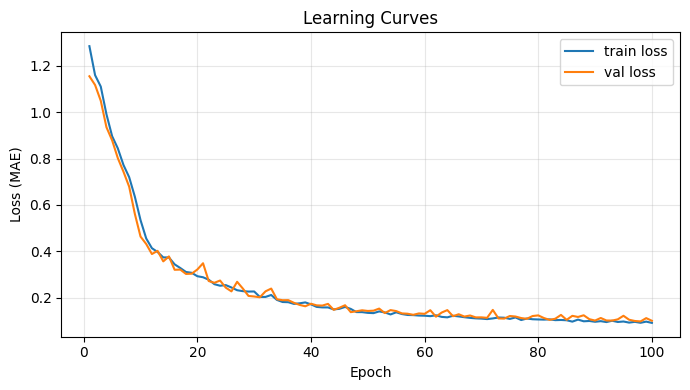


Validation set results:

circle: MAE=0.079  RMSE=0.114
square: MAE=0.129  RMSE=0.188
triangle: MAE=0.083  RMSE=0.122
Saved scatter plot to actual_vs_pred.png


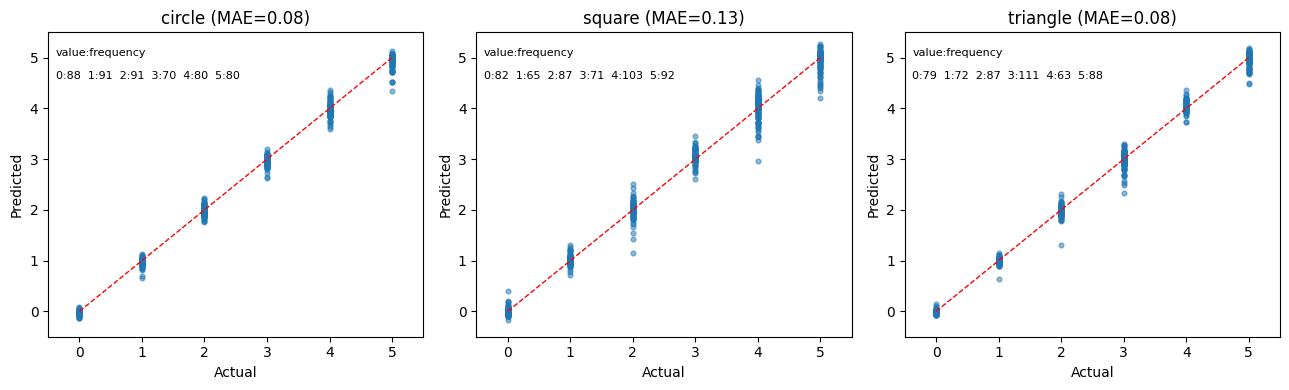

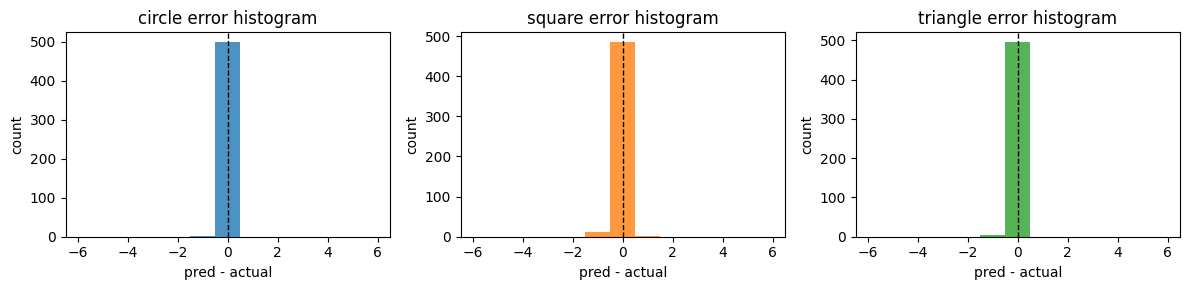

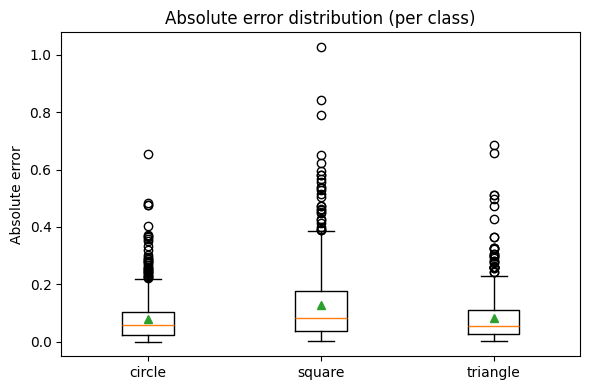

circle: % within ±1 = 100.0%, % within ±2 = 100.0%
square: % within ±1 = 99.8%, % within ±2 = 100.0%
triangle: % within ±1 = 100.0%, % within ±2 = 100.0%

Done. Best epoch: 98  best_val: 0.0970

Test set results:

circle: MAE=0.080  RMSE=0.112
square: MAE=0.143  RMSE=0.206
triangle: MAE=0.080  RMSE=0.120
Saved scatter plot to test_actual_vs_pred.png


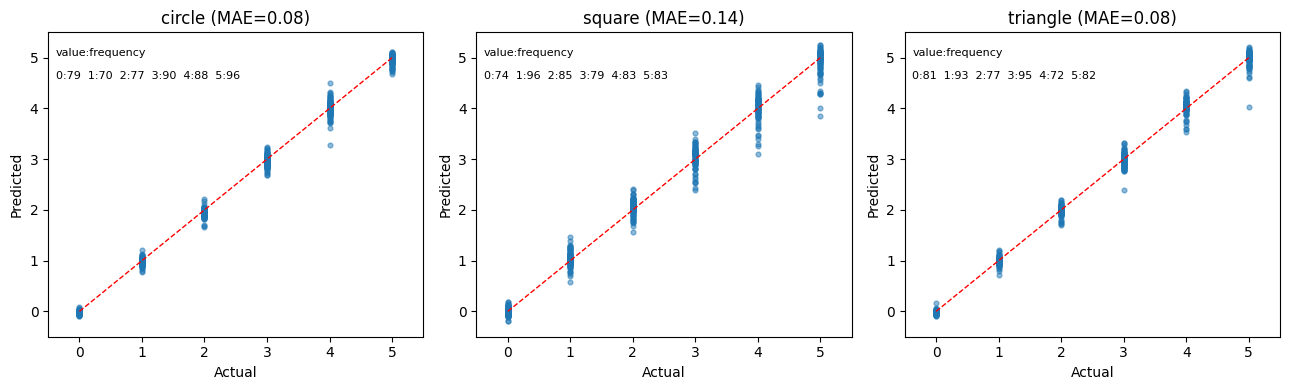

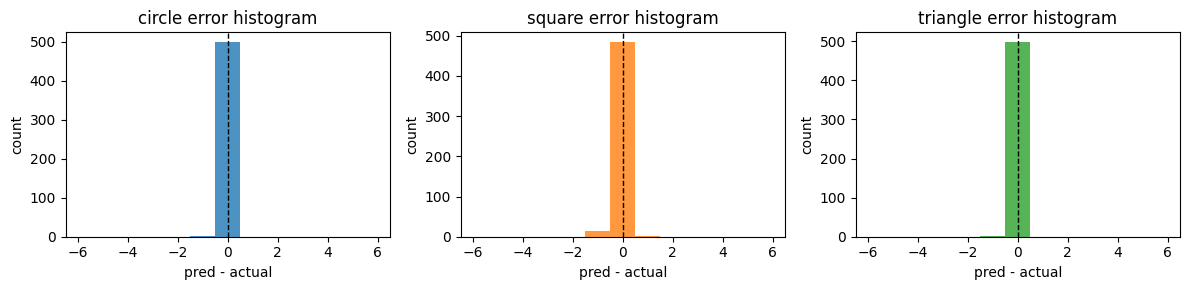

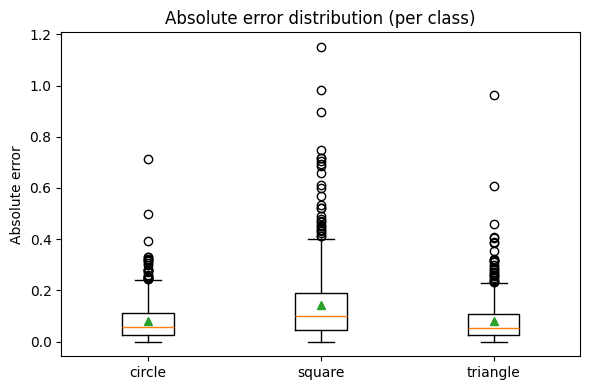

circle: % within ±1 = 100.0%, % within ±2 = 100.0%
square: % within ±1 = 99.8%, % within ±2 = 100.0%
triangle: % within ±1 = 100.0%, % within ±2 = 100.0%


Saved confusion matrices to confusion_matrices.png
Confusion Matrices (rows: actual, columns: predicted) for each shape of test set:


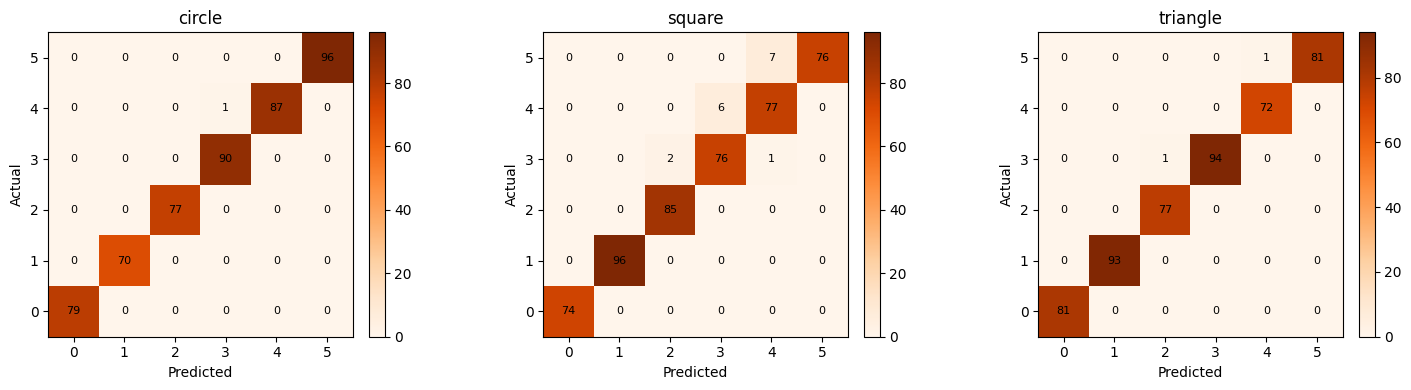


Classification metrics table on test set:
    class  accuracy  precision_macro  recall_macro  f1_macro
   circle  0.998000         0.998168      0.998106  0.998127
   square  0.968000         0.968287      0.967566  0.967519
 triangle  0.996000         0.995580      0.996213  0.995871
macro_avg  0.987333         0.987345      0.987295  0.987172

**************** All done! ****************


In [18]:
if __name__ == "__main__":
    model, val_loader, device, val_ds, test_loader, test_ds, best_epoch, best_val, train_losses, val_losses, test_mae, test_rmse, ys_true_t, ys_pred_t = train()
    
    ''' Plot learning curves '''
    plot_learning_curves(train_losses, val_losses, out="learning_curves.png")
    ''' Scatter plot actual vs predicted '''
    print()
    print("Validation set results:")
    print()
    plot_actual_vs_pred(model, val_loader, device)
    plot_error_hist_and_box(model, val_loader, device)
    print()
    print(f"Done. Best epoch: {best_epoch}  best_val: {best_val:.4f}")
    print()
    print("Test set results:")
    print()
    plot_actual_vs_pred(model, test_loader, device, out="test_actual_vs_pred.png")
    plot_error_hist_and_box(model, test_loader, device, out_hist="test_error_hist.png", out_box="test_error_box.png")
    print()
    plot_confusion_matrices(ys_true_t, ys_pred_t, max_count=MAX_EACH, normalize=False)
    print()
    '''compute metrics table '''
    table = classification_metrics_table(ys_true_t, ys_pred_t, max_count=MAX_EACH) 
    print("Classification metrics table on test set:")
    print(table.to_string(index=False))
    print()
    print("**************** All done! ****************")
  